In [1]:
import torch
import torch.nn.functional as F
import torchvision

import matplotlib.pyplot as plt

from torch import nn, optim
from torchvision.utils import make_grid

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
def show_batch(batch):
    im = torchvision.utils.make_grid(batch)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

In [3]:
batch_size = 32

transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
])

train_data = torchvision.datasets.MNIST(
    '/media/akir/DATA/ml-data/',
    train=True,
    download=True,
    transform=transform,
)

digit1 = 0
digit2 = 8

bad_digit = 6

train_idxs = np.where((train_data.targets == digit1) | (train_data.targets == digit2))[0]
train_dataset = torch.utils.data.Subset(train_data, train_idxs)
train_dataset.dataset.targets[np.where(train_dataset.dataset.targets == digit1)] = 0
train_dataset.dataset.targets[np.where(train_dataset.dataset.targets == digit2)] = 1

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_data = torchvision.datasets.MNIST(
    '/media/akir/DATA/ml-data/',
    train=False,
    download=True,
    transform=transform,
)

test_idxs = np.where((test_data.targets == digit1) | (test_data.targets == digit2))[0]
test_dataset = torch.utils.data.Subset(test_data, test_idxs)
test_dataset.dataset.targets[np.where(test_dataset.dataset.targets == digit1)] = 0
test_dataset.dataset.targets[np.where(test_dataset.dataset.targets == digit2)] = 1

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


bad_data = torchvision.datasets.MNIST(
    '/media/akir/DATA/ml-data/',
    train=False,
    download=True,
    transform=transform,
)

bad_idxs = np.where(bad_data.targets == bad_digit)[0]
bad_dataset = torch.utils.data.Subset(bad_data, bad_idxs)
bad_dataloader = torch.utils.data.DataLoader(bad_dataset, batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels: tensor([0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
        0, 0, 1, 0, 0, 1, 0, 1])


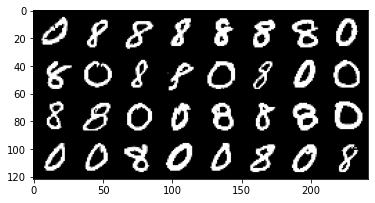

In [4]:
images, labels = next(iter(train_dataloader))
print(f'Labels: {labels}')
show_batch(images)

In [5]:
class ConvNet(nn.Module):
    def __init__(self, p):
        super().__init__()
        self.p = p
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout = nn.Dropout(self.p)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [6]:
def train(dataloader, model, optimizer, criterion, device, n_epochs=50, losses=[]):

    model.train()

    for epoch in range(n_epochs):
        
        for i, batch in enumerate(dataloader):
            X, y = batch
            
            X = X.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            y_pred = model(X)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            
            losses.append(loss)

        print(f'Epoch: {epoch}, loss: {loss}')


In [7]:
n_epochs = 3
lr = 0.005
p = 0.75

model = ConvNet(p).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

train(train_dataloader, model, optimizer, criterion, device, n_epochs)

Epoch: 0, loss: 0.20956610143184662
Epoch: 1, loss: 0.13830624520778656
Epoch: 2, loss: 0.018546858802437782


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels: tensor([0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
        0, 0, 1, 1, 1, 1, 0, 0])


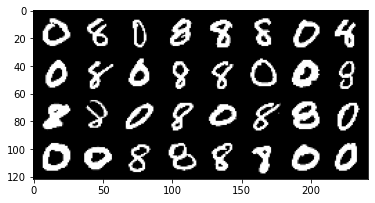

In [8]:
images, labels = next(iter(test_dataloader))
print(f'Labels: {labels}')
show_batch(images)

## Adversarial

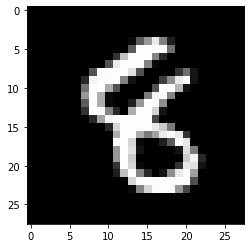

In [9]:
bad_image_id = torch.where(labels == 1)[0][0]

bad_image = images[bad_image_id].clone()
plt.imshow(bad_image[0], cmap='gray')

In [10]:
bad_image = bad_image.to(device)
bad_image.requires_grad = True

y = torch.tensor([0]).to(device)

lr = 0.1

model.eval()

ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout): Dropout(p=0.75, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [11]:
while True:
    bad_image.grad = None

    y_pred = model(bad_image.unsqueeze(0))
    print(f' - softmax probs: {torch.softmax(y_pred, dim=1)}')

    loss = criterion(y_pred, y)
    print(f' - loss: {loss}')
    loss.backward()

    bad_image.data -= lr * bad_image.grad

    if y_pred[0][0] > 0.5:
        break

 - softmax probs: tensor([[0.0212, 0.9788]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 3.8548293113708496
 - softmax probs: tensor([[0.0216, 0.9784]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 3.8350982666015625
 - softmax probs: tensor([[0.0220, 0.9780]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 3.815317392349243
 - softmax probs: tensor([[0.0225, 0.9775]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 3.7955572605133057
 - softmax probs: tensor([[0.0229, 0.9771]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 3.776024580001831
 - softmax probs: tensor([[0.0234, 0.9766]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 3.756944417953491
 - softmax probs: tensor([[0.0238, 0.9762]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 3.737884044647217
 - softmax probs: tensor([[0.0243, 0.9757]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 3.7188377380371094
 - softmax probs: tensor([[0.0247, 0.9753]], device='cuda:0', grad_f

 - loss: 2.0711872577667236
 - softmax probs: tensor([[0.1275, 0.8725]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 2.059920072555542
 - softmax probs: tensor([[0.1289, 0.8711]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 2.048689603805542
 - softmax probs: tensor([[0.1304, 0.8696]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 2.037506580352783
 - softmax probs: tensor([[0.1318, 0.8682]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 2.0263545513153076
 - softmax probs: tensor([[0.1333, 0.8667]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 2.015228748321533
 - softmax probs: tensor([[0.1348, 0.8652]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 2.004164218902588
 - softmax probs: tensor([[0.1362, 0.8638]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 1.9936466217041016
 - softmax probs: tensor([[0.1376, 0.8624]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 1.9831339120864868
 - softmax probs: tensor([[0.1391, 0.8609

 - softmax probs: tensor([[0.2908, 0.7092]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 1.2350598573684692
 - softmax probs: tensor([[0.2919, 0.7081]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 1.2312722206115723
 - softmax probs: tensor([[0.2930, 0.7070]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 1.2275009155273438
 - softmax probs: tensor([[0.2941, 0.7059]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 1.2237756252288818
 - softmax probs: tensor([[0.2952, 0.7048]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 1.2201298475265503
 - softmax probs: tensor([[0.2963, 0.7037]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 1.2164760828018188
 - softmax probs: tensor([[0.2974, 0.7026]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 1.2128345966339111
 - softmax probs: tensor([[0.2984, 0.7016]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 1.2092053890228271
 - softmax probs: tensor([[0.2995, 0.7005]], device='cuda:0', gr

 - softmax probs: tensor([[0.3953, 0.6047]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 0.9280977249145508
 - softmax probs: tensor([[0.3960, 0.6040]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 0.926306962966919
 - softmax probs: tensor([[0.3967, 0.6033]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 0.9245222806930542
 - softmax probs: tensor([[0.3974, 0.6026]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 0.9227567911148071
 - softmax probs: tensor([[0.3981, 0.6019]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 0.9210798144340515
 - softmax probs: tensor([[0.3988, 0.6012]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 0.9194084405899048
 - softmax probs: tensor([[0.3994, 0.6006]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 0.917740523815155
 - softmax probs: tensor([[0.4001, 0.5999]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 0.9160783290863037
 - softmax probs: tensor([[0.4007, 0.5993]], device='cuda:0', grad

 - softmax probs: tensor([[0.4528, 0.5472]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 0.7922804355621338
 - softmax probs: tensor([[0.4534, 0.5466]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 0.7908868789672852
 - softmax probs: tensor([[0.4541, 0.5459]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 0.7894243001937866
 - softmax probs: tensor([[0.4549, 0.5451]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 0.7877610921859741
 - softmax probs: tensor([[0.4556, 0.5444]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 0.7861050367355347
 - softmax probs: tensor([[0.4564, 0.5436]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 0.7844641208648682
 - softmax probs: tensor([[0.4571, 0.5429]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 0.7828282117843628
 - softmax probs: tensor([[0.4579, 0.5421]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 0.7811974287033081
 - softmax probs: tensor([[0.4586, 0.5414]], device='cuda:0', gr

 - softmax probs: tensor([[0.5144, 0.4856]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 0.6647697687149048
 - softmax probs: tensor([[0.5151, 0.4849]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 0.6633902192115784
 - softmax probs: tensor([[0.5158, 0.4842]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 0.662014901638031
 - softmax probs: tensor([[0.5167, 0.4833]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 0.6603065729141235
 - softmax probs: tensor([[0.5176, 0.4824]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 0.6584601998329163
 - softmax probs: tensor([[0.5186, 0.4814]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 0.6566203236579895
 - softmax probs: tensor([[0.5196, 0.4804]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 0.6547882556915283
 - softmax probs: tensor([[0.5205, 0.4795]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 0.6529027223587036
 - softmax probs: tensor([[0.5216, 0.4784]], device='cuda:0', gra

 - softmax probs: tensor([[0.6016, 0.3984]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 0.5080899596214294
 - softmax probs: tensor([[0.6027, 0.3973]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 0.5063087940216064
 - softmax probs: tensor([[0.6038, 0.3962]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 0.5045418739318848
 - softmax probs: tensor([[0.6048, 0.3952]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 0.5027884244918823
 - softmax probs: tensor([[0.6059, 0.3941]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 0.5009651780128479
 - softmax probs: tensor([[0.6070, 0.3930]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 0.49915724992752075
 - softmax probs: tensor([[0.6082, 0.3918]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 0.4973319172859192
 - softmax probs: tensor([[0.6093, 0.3907]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 0.4955177903175354
 - softmax probs: tensor([[0.6104, 0.3896]], device='cuda:0', g

 - loss: 0.3680158853530884
 - softmax probs: tensor([[0.6929, 0.3071]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 0.3668132424354553
 - softmax probs: tensor([[0.6938, 0.3062]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 0.3656214773654938
 - softmax probs: tensor([[0.6946, 0.3054]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 0.36443811655044556
 - softmax probs: tensor([[0.6954, 0.3046]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 0.3632631003856659
 - softmax probs: tensor([[0.6962, 0.3038]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 0.3621075451374054
 - softmax probs: tensor([[0.6970, 0.3030]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 0.36096200346946716
 - softmax probs: tensor([[0.6978, 0.3022]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 0.3598308563232422
 - softmax probs: tensor([[0.6986, 0.3014]], device='cuda:0', grad_fn=<SoftmaxBackward>)
 - loss: 0.3587058484554291
 - softmax probs: tensor([[0.6994,

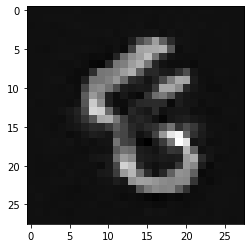

In [20]:
plt.imshow(bad_image[0].detach().cpu(), cmap='gray')
plt.savefig('images/zero-adversarial.jpg')

## Normal

In [13]:
model = model.eval()
y_hat = model(bad_image[:, None].to(device))
outputs = torch.exp(F.log_softmax(y_hat, dim=1))
outputs[0][0].item(), outputs[0][1].item()

(0.7290651798248291, 0.2709348201751709)

## MC Dropout

In [21]:
def mc_predict(model, device, X, T=1000):
    model = model.train()
    outputs = torch.zeros(T, 2).to(device)

    for i in range(T):
        y_hat = model(X[:, None].to(device))
        outputs[i] = F.log_softmax(y_hat, dim=1)
    
    return torch.exp(outputs)

In [22]:
T = 1000
mcs = mc_predict(model, device, bad_image, T)

### Variation ratio

In [23]:
mode = torch.mode(mcs.argmax(axis=1))[0]
mode

tensor(0, device='cuda:0')

In [24]:
n_mode = torch.sum(mcs.argmax(axis=1) == mode)
n_mode

tensor(874, device='cuda:0')

In [25]:
# max = 0.5 when classes are sampled equally likely
# min = 0   when only a single class is sampled
variation_ratio = 1. - n_mode.type(torch.float)/T
variation_ratio

tensor(0.1260, device='cuda:0')

### Predictive entropy

In [26]:
# min = 0  when only a single class is sampled
# max = 0.5  when classes are sampled equally likely
-torch.sum(mcs.mean(axis=0)*torch.log(mcs.mean(axis=0)))

tensor(0.4714, device='cuda:0', grad_fn=<NegBackward>)